In [6]:
import os 
os.chdir('/Users/cecileherbermann/Downloads')

Note: you may need to restart the kernel to use updated packages.
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_.T + self.intercept_
Fitting dispersions...
... done in 1.38 seconds.

Fitting dispersion trend curve...
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:209: RuntimeWarning: divide by zero encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:209: RuntimeWarning: o

Log2 fold change & Wald test p-value: condition missense mutation vs isogenic wildtype
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P           10.166782       -0.183302  0.479469 -0.382302  0.702237   
LOC124900384      4.156026        0.058994  0.715492  0.082453  0.934287   
LOC729737        82.736561        0.419733  0.215456  1.948110  0.051402   
LOC100996442      3.080366        0.306275  0.832452  0.367919  0.712934   
LOC127239154     26.668831       -0.083397  0.358610 -0.232557  0.816105   
...                    ...             ...       ...       ...       ...   
ND4           47277.740483        0.252508  0.116204  2.172964  0.029783   
ND5           36286.196697        0.162965  0.128798  1.265277  0.205772   
ND6            3259.016280        0.217573  0.142125  1.530849  0.125807   
CYTB          38661.053586        0.381925  0.125702  3.038331  0.002379   
TRNP             71.017533       -0.352134  0.293207 -1.200974  0.229761   



Fitting dispersions...
... done in 1.44 seconds.

/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:209: RuntimeWarning: divide by zero encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:209: RuntimeWarning: overflow encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:209: RuntimeWarning: invalid value encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:213: RuntimeWarning: divide by zero encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.13/site-packages/pydeseq2/default_inference.py:213: RuntimeWarning: overflow encountered in matmul
  mu = covariates_fit @ coeffs
/Users/cecileherbermann/miniconda3/lib/python3.1

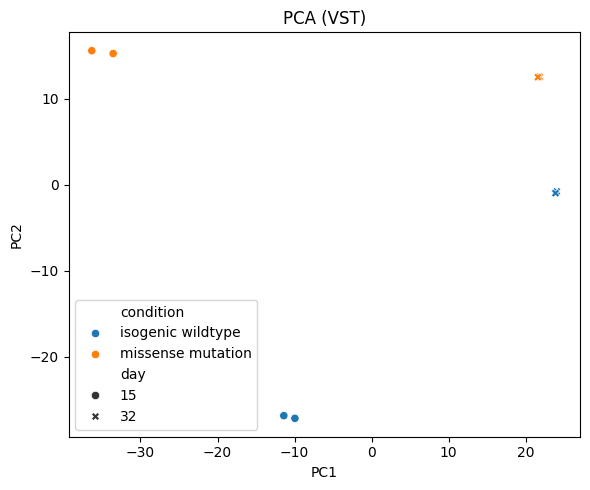

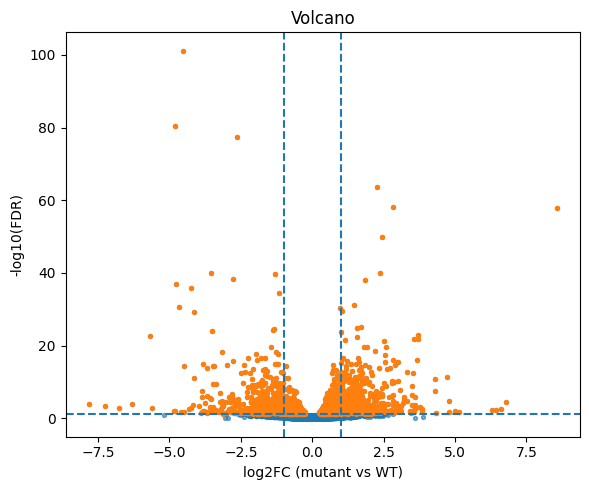

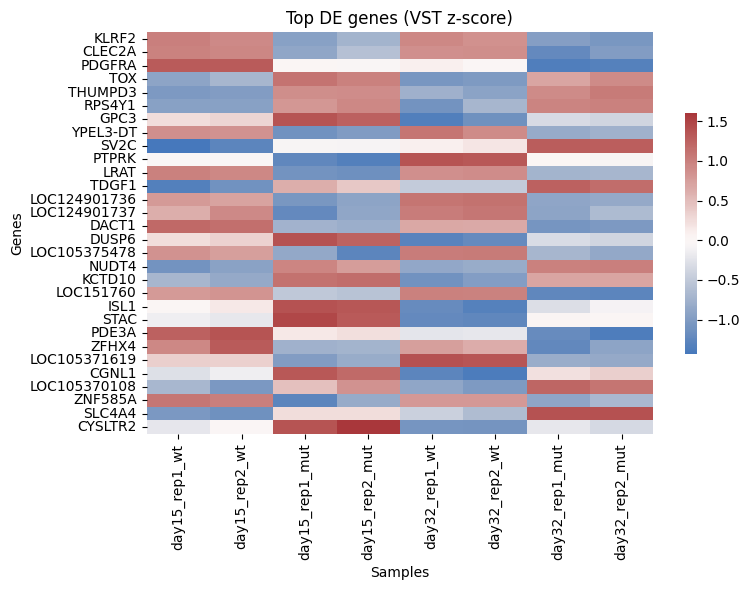

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms; optional_attrs(relationship)
HMS:0:00:40.067568 503,951 annotations, 20,835 genes, 18,905 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 90% 18,800 of 20,806 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 96% 19,896 of 20,806 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 89% 18,610 of 20,806 population items found in association

Runing BP Ontology Analysis: current study set of 1289 IDs.
 94%  1,211 of  1,289 study items found in association
100%  1,289 of  1,289 study items found in population(20806)
Calculating 14,608 uncorrected p-values using fisher_scipy_stats
  14,608 terms are associated with 18,800 of 20,806 population items
   7,462 terms are associated with  1,211 of  1,289 study items
  METHOD fdr_bh:
     504

In [14]:
# installs
%pip install scanpy pydeseq2 goatools mygene

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds  import DeseqStats

from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
import urllib.request
import mygene
import os

# --- paths & settings ---
COUNTS_PATH = "dataset2.txt"              # genes x samples (TSV; first col = gene)
META_PATH   = "dataset2_metadata.csv"     # includes: sample_id, day, stage, condition
KEEP_STAGE  = "cardiomyocyte"
KEEP_DAYS   = [15, 32]
MUT_LABEL   = "missense mutation"
WT_LABEL    = "isogenic wildtype"

# --- load ---
counts = pd.read_csv(COUNTS_PATH, sep="\t", index_col=0)
meta   = pd.read_csv(META_PATH)

# tidy meta
meta.columns = [c.strip().replace(" ", "_") for c in meta.columns]
for c in ("sample_id","stage","condition"):
    if c in meta.columns:
        meta[c] = meta[c].astype(str).str.strip()

# align
samples = [s for s in meta.sample_id if s in counts.columns]
counts = counts.loc[:, samples]
meta   = meta.set_index("sample_id").loc[samples].copy()

# subset stage/days
meta["stage"] = meta["stage"].str.lower()
sel = (meta.stage == KEEP_STAGE) & (meta.day.astype(int).isin(KEEP_DAYS))
meta   = meta.loc[sel]
counts = counts.loc[:, meta.index]

# filter low-abundance (>=10 total counts)
counts = counts[counts.sum(axis=1) >= 10]

# ensure integers
counts = counts.fillna(0)
if not np.issubdtype(counts.dtypes.values[0], np.integer):
    counts = counts.round().astype(int)

# --- DE with PyDESeq2: ~ day + condition ---
cts = counts.T.copy()                # samples x genes
meta["day"] = meta["day"].astype(int)
meta["condition"] = meta["condition"].astype("category")

dds = DeseqDataSet(counts=cts, metadata=meta, design="~ day + condition", refit_cooks=True)
dds.deseq2()
stats = DeseqStats(dds, contrast=("condition", MUT_LABEL, WT_LABEL))
stats.summary()  # <-- run the Wald test & build the results table
res = stats.results_df.sort_values("padj")

res.to_csv("DE_results_mutant_vs_WT.csv")
print(res.head(10))

# --- VST for visuals ---
dds.vst(use_design=False)
vst = pd.DataFrame(dds.layers["vst_counts"], index=cts.index, columns=cts.columns).loc[meta.index]

# --- PCA ---
topv = vst.var(axis=0).sort_values(ascending=False).head(1000).index
X = StandardScaler().fit_transform(vst[topv].values)
pc = PCA(n_components=2).fit_transform(X)
pc_df = pd.DataFrame(pc, index=vst.index, columns=["PC1","PC2"]).join(meta[["condition","day"]])

plt.figure(figsize=(6,5))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="condition", style="day")
plt.title("PCA (VST)")
plt.tight_layout(); plt.savefig("PCA_vst.png", dpi=180); plt.show()

# --- Volcano ---
volc = res.dropna(subset=["log2FoldChange","padj"]).copy()
plt.figure(figsize=(6,5))
plt.scatter(volc["log2FoldChange"], -np.log10(volc["padj"]), s=8, alpha=0.6)
sig = volc["padj"] < 0.05
plt.scatter(volc.loc[sig,"log2FoldChange"], -np.log10(volc.loc[sig,"padj"]), s=8)
plt.axvline( 1, ls="--"); plt.axvline(-1, ls="--"); plt.axhline(-np.log10(0.05), ls="--")
plt.xlabel("log2FC (mutant vs WT)"); plt.ylabel("-log10(FDR)"); plt.title("Volcano")
plt.tight_layout(); plt.savefig("volcano.png", dpi=180); plt.show()

# --- Heatmap (top 30 DE) ---
top_genes = volc.sort_values("padj").head(30).index.tolist()
hm = vst[top_genes]
hm_z = (hm - hm.mean(axis=0)) / (hm.std(axis=0) + 1e-8)
plt.figure(figsize=(8,6))
sns.heatmap(hm_z.T, cmap="vlag", center=0, cbar_kws={"shrink":0.6})
plt.title("Top DE genes (VST z-score)")
plt.xlabel("Samples"); plt.ylabel("Genes")
plt.tight_layout(); plt.savefig("heatmap_topDE.png", dpi=180); plt.show()

# --- GO enrichment (GOATOOLS; up & down separately) --------------------------
# Map symbols -> Entrez
import mygene
mg = mygene.MyGeneInfo()

def sym2entrez(symbols):
    if not symbols:
        return {}
    q = mg.querymany(
        symbols, scopes="symbol", fields="entrezgene,taxid",
        species="human", as_dataframe=True, df_index=True, verbose=False
    )
    out = {}
    for sym, row in q.iterrows():
        try:
            if int(row.get("taxid", 0)) == 9606 and not pd.isna(row.get("entrezgene", np.nan)):
                out[sym] = int(row["entrezgene"])
        except Exception:
            pass
    return out

sig_up   = volc[(volc["padj"]<0.05) & (volc["log2FoldChange"]>0)].index.tolist()   # up in mutant
sig_down = volc[(volc["padj"]<0.05) & (volc["log2FoldChange"]<0)].index.tolist()   # up in WT
universe = counts.index.tolist()

map_univ = sym2entrez(universe)
map_up   = {s: map_univ[s] for s in sig_up   if s in map_univ}
map_down = {s: map_univ[s] for s in sig_down if s in map_univ}

# Ontology
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
obo = download_go_basic_obo()
obodag = GODag(obo, optional_attrs={'relationship'})

# --- Gene2Go associations (decompress .gz, then read) ---
from goatools.anno.genetogo_reader import Gene2GoReader
import urllib.request, os, gzip, shutil

g2g_gz  = "gene2go.gz"
g2g_txt = "gene2go"  # decompressed text file

# download if missing
if not os.path.exists(g2g_gz):
    urllib.request.urlretrieve(
        "https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz", g2g_gz
    )

# decompress once (idempotent)
if not os.path.exists(g2g_txt):
    with gzip.open(g2g_gz, "rb") as fin, open(g2g_txt, "wb") as fout:
        shutil.copyfileobj(fin, fout)

# read human associations
g2g_reader = Gene2GoReader(g2g_txt, taxids=[9606])
ns2assoc = g2g_reader.get_ns2assc()   # {'BP': {geneid: set(GOIDs)}, 'MF': {...}, 'CC': {...}}

# Population: genes present in any namespace
pop_geneids = sorted({gid for assoc in ns2assoc.values() for gid in assoc})
study_up    = [eid for eid in map_up.values()   if eid in pop_geneids]
study_down  = [eid for eid in map_down.values() if eid in pop_geneids]

from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goea = GOEnrichmentStudyNS(
    pop_geneids,
    ns2assoc,                 # per-namespace associations
    obodag,
    propagate_counts=True,
    alpha=0.05,
    methods=["fdr_bh"]
)

def run_go(study_ids, out_csv):
    if len(study_ids) == 0:
        pd.DataFrame(columns=["GO_ID","name","namespace","study_ratio","pop_ratio","p_fdr_bh"]).to_csv(out_csv, index=False)
        return
    res = goea.run_study(study_ids)
    rows = []
    for r in res:
        if r.p_fdr_bh < 0.05:
            rows.append({
                "GO_ID": r.GO,
                "name": r.name,
                "namespace": r.NS,  # BP/CC/MF
                "study_ratio": f"{r.study_count}/{r.study_n}",
                "pop_ratio":   f"{r.pop_count}/{r.pop_n}",
                "p_fdr_bh": r.p_fdr_bh
            })
    pd.DataFrame(rows).sort_values(["namespace","p_fdr_bh","name"]).to_csv(out_csv, index=False)

run_go(study_up,   "GO_enrichment_up_in_mutant.csv")
run_go(study_down, "GO_enrichment_up_in_WT.csv")

print("Done:")
print("- DE_results_mutant_vs_WT.csv")
print("- PCA_vst.png, volcano.png, heatmap_topDE.png")
print("- GO_enrichment_up_in_mutant.csv, GO_enrichment_up_in_WT.csv")
